In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:

class PIDController:
    def __init__(self, Kp, Ki, Kd, output_limits=(None, None)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        self.output_min, self.output_max = output_limits
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term with anti-windup
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term with filtering
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Compute output
        output = P + I + D
        
        # Apply output limits and anti-windup
        if self.output_min is not None and self.output_max is not None:
            output = np.clip(output, self.output_min, self.output_max)
            if output != P + I + D:  # If saturated
                self.integral -= error * dt  # Anti-windup
                
        self.prev_error = error
        return output


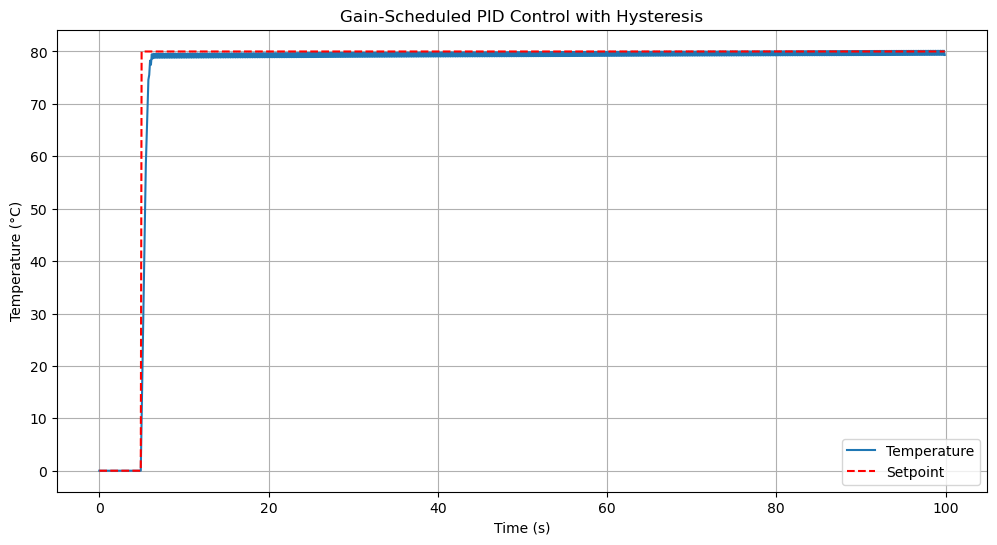

In [3]:

class GainScheduledPID:
    def __init__(self, pid_params, output_limits=(None, None)):
        """
        pid_params: List of (condition_function, Kp, Ki, Kd) tuples
        output_limits: Tuple of (min, max) output constraints
        """
        self.pid_params = pid_params
        self.output_limits = output_limits
        # Initialize with first set of parameters
        self.current_pid = PIDController(*pid_params[0][1:], output_limits)
        self.current_condition = pid_params[0][0]
        
    def compute(self, setpoint, pv, dt):
        # Find appropriate parameters
        for condition, Kp, Ki, Kd in self.pid_params:
            if condition(setpoint, pv):
                # Only update if condition changed (saves computation)
                if condition != self.current_condition:
                    self.current_pid.Kp = Kp
                    self.current_pid.Ki = Ki
                    self.current_pid.Kd = Kd
                    self.current_condition = condition
                break
                
        return self.current_pid.compute(setpoint, pv, dt)

# Example Usage with Hysteresis
def low_temp_condition(setpoint, pv):
    return pv < 45  # Switch to low gains below 45°C

def high_temp_condition(setpoint, pv):
    return pv >= 55  # Switch to high gains above 55°C (hysteresis band)

pid_params = [
    (low_temp_condition, 30, 0.5, 5),   # Aggressive at low temps
    (high_temp_condition, 15, 0.2, 1)   # Conservative at high temps
]

# Simulation parameters
dt = 0.1
total_time = 100
time = np.arange(0, total_time, dt)
temp = np.zeros_like(time)
setpoint = np.zeros_like(time)
setpoint[50:] = 80  # Step change at t=5s

# System model (simple first-order with nonlinearity)
def system_update(control, current_temp, dt):
    # System becomes less responsive at higher temps
    efficiency = 1.0 if current_temp < 50 else 0.6
    return current_temp + efficiency * control * dt - 0.1 * current_temp * dt

# Create controller
scheduled_pid = GainScheduledPID(pid_params, output_limits=(0, 100))

# Run simulation
for i in range(1, len(time)):
    control = scheduled_pid.compute(setpoint[i], temp[i-1], dt)
    temp[i] = system_update(control, temp[i-1], dt)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(time, temp, label='Temperature')
plt.plot(time, setpoint, 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Gain-Scheduled PID Control with Hysteresis')
plt.legend()
plt.grid(True)
plt.show()